In [1]:
import torch
from loopy import Train,Evaluate
from loopy.myData import DataBuffer
from loopy.Train import train_log
from random import choice

from torch import optim
from torch.utils.data import DataLoader

import os
print(torch.__version__)

#工具包
import loopy.utils as ut


#损失函数等
from torch.optim.lr_scheduler import StepLR
from torch.nn.parallel import DataParallel



2.1.0


In [2]:
workdir = "/share/home/xingzt/Jupyter_dir/Final_Solution/Solution4/loopy_deploy/"   #工作目录
os.chdir(workdir)

#参数定义区
posdata = "data/Rand-90.fasta"   #正例文件
tsdata = "data/Rand-10.fasta"
tsnegpath = "data/neg_5k-10.fasta"
logfile = "log/unet-2.txt"
parafile = "para/"
#额外负例
negpath = "data/neg5000-08.fasta"

#监控的名称
namelis = [["loss","testloss"],["Point-acc","Ptestacc","Region-acc","Rtestacc"],["Point-Precisson","PtestPrecission","Point-Recall","PtestRecll"],
           ["Point-F1","PtestF1"],["Region-Precission","RtestPrecission","Region-Recall","RtestRecall"],["Region-F1","RtestF1"]]
colors = [[None,None],[None,None,None,None],[None,None,None,None],[None,None],[None,None,None,None],[None,None]]
colors = ut.randcolor_lis(colors)

printmode = "pic"
shownum = 400

#初始损失
ini_lr = 0.0016
decay_rounds = 10
decay = 0.9

#
maxlen = 5000
epochs = 100
pvalue = 0.06


#评估参数
windowlen = 200
windowstep = 10
#采用的模型
from loopy.Model.Unet import Unet as Model

# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
os.chdir(workdir)

#日志文件
train_log = train_log(
    namelis,
    logfile,
    colors=colors,
    mode=printmode,
    shownum=shownum,
    env="Jupter"
)

#加载数据
traindata = DataBuffer(
    posdata,
    maxlen,
    zoomrate=1,
    label_mode="si",
    tech_score=None,
    strand=True
)
traindata.addneg(
    path=negpath
)
testdata = DataBuffer(
    tsdata,
    maxlen,
    zoomrate=1,
    label_mode="si",
    tech_score=None,
    strand=True
)
testdata.addneg(
    path=tsnegpath
)
# tsData = DataBuffer(
#     tsdata,
#     maxlen,
#     zoomrate=1,
#     label_mode="si",
#     tech_score=None,
#     strand=True
# )
# print(len(tsData))
# # tsData.addneg(
# #     path="data/neg-0005.fasta"
# # )
# # print(len(tsData))

train_loader = DataLoader(
    dataset=traindata,
    batch_size=64,
    shuffle=True,
    num_workers=1
)
test_loader = DataLoader(
    dataset=testdata,
    batch_size=64,
    shuffle=True,
    num_workers=1
)



3210


In [23]:
import torch.nn as nn
def init_weights(m):
    if type(m) == nn.LSTM:
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
    elif type(m) == nn.Linear:
        torch.nn.init.orthogonal_(m.weight)
        m.bias.data.fill_(0)
    else:
        ut.initialize_weights(m)

#实例化模型
model = Model().to(device)
model = DataParallel(model)

# print(parafile)
# if os.path.exists(parafile):
#     print("文件存在")
# else:
#     print("文件不存在")
readpara = r"para/just_tuning.pth"
if os.path.exists(parafile):
    model.load_state_dict(torch.load(parafile))
    print("read")
else:
#     for name in model.modules():
#         init_weights(name)
    pass
# model = DataParallel(model)

#     ut.initialize_weights(model)

#将分布的模型保存成单个



read


In [24]:
torch.save(model.module.state_dict(), parafile)

In [7]:
#模型工具定义
#优化器
import torch.nn.functional as F
optimizer = optim.Adam(model.parameters(),lr=ini_lr,betas=(0.9, 0.999), eps=1e-8,) #weight_decay=0.0001
scheduler = StepLR(optimizer, step_size=decay_rounds, gamma=decay)
#损失函数
crt = torch.nn.BCELoss().to(device) # weight=torch.Tensor([1.0,27.0])

class WeightedBCELoss(torch.nn.Module):
    def __init__(self,):
        super(WeightedBCELoss, self).__init__()
        self.bgweight = 1
        self.pvalue = 0.5

    def forward(self, input_, target):
        weights = self.makeweight(target)  # 设置为0的位置权重很低，为1的位置权重较高
        loss = (F.binary_cross_entropy(input_, target, weight=weights, reduction='mean') + F.binary_cross_entropy(target, input_, weight=weights, reduction='mean'))/2
        return loss
    
    def makeweight(self,label:torch.Tensor):
        weights = []
        for i in range(label.shape[0]):
            rloop = label[i]
            # 统计大于阈值的元素个数
            count = torch.sum(rloop > self.pvalue).item()
            # 计算大于阈值的比例
            ratio = count / rloop.numel()
            wgt = self.get_wgt(ratio)
            weights.append(rloop.detach()*wgt[1]+wgt[0])
        return torch.stack(weights,dim=0)

    def get_wgt(self,ratio):
        for v,k in self.weights.items():
            if ratio <= v:
                return k
        

#损失函数
lossfunc = WeightedBCELoss()

In [8]:
# if os.path.exists(parafile):
#     model.load_state_dict(torch.load(parafile))
# else:
#     ut.initialize_weights(model)
# torch.autograd.set_detect_anomaly(True)

Train.train(
    model,optimizer,scheduler,epochs,lossfunc,"hc",train_loader,train_log,device,pvalue,0,windowlen,windowstep,parafile,test_loader
)

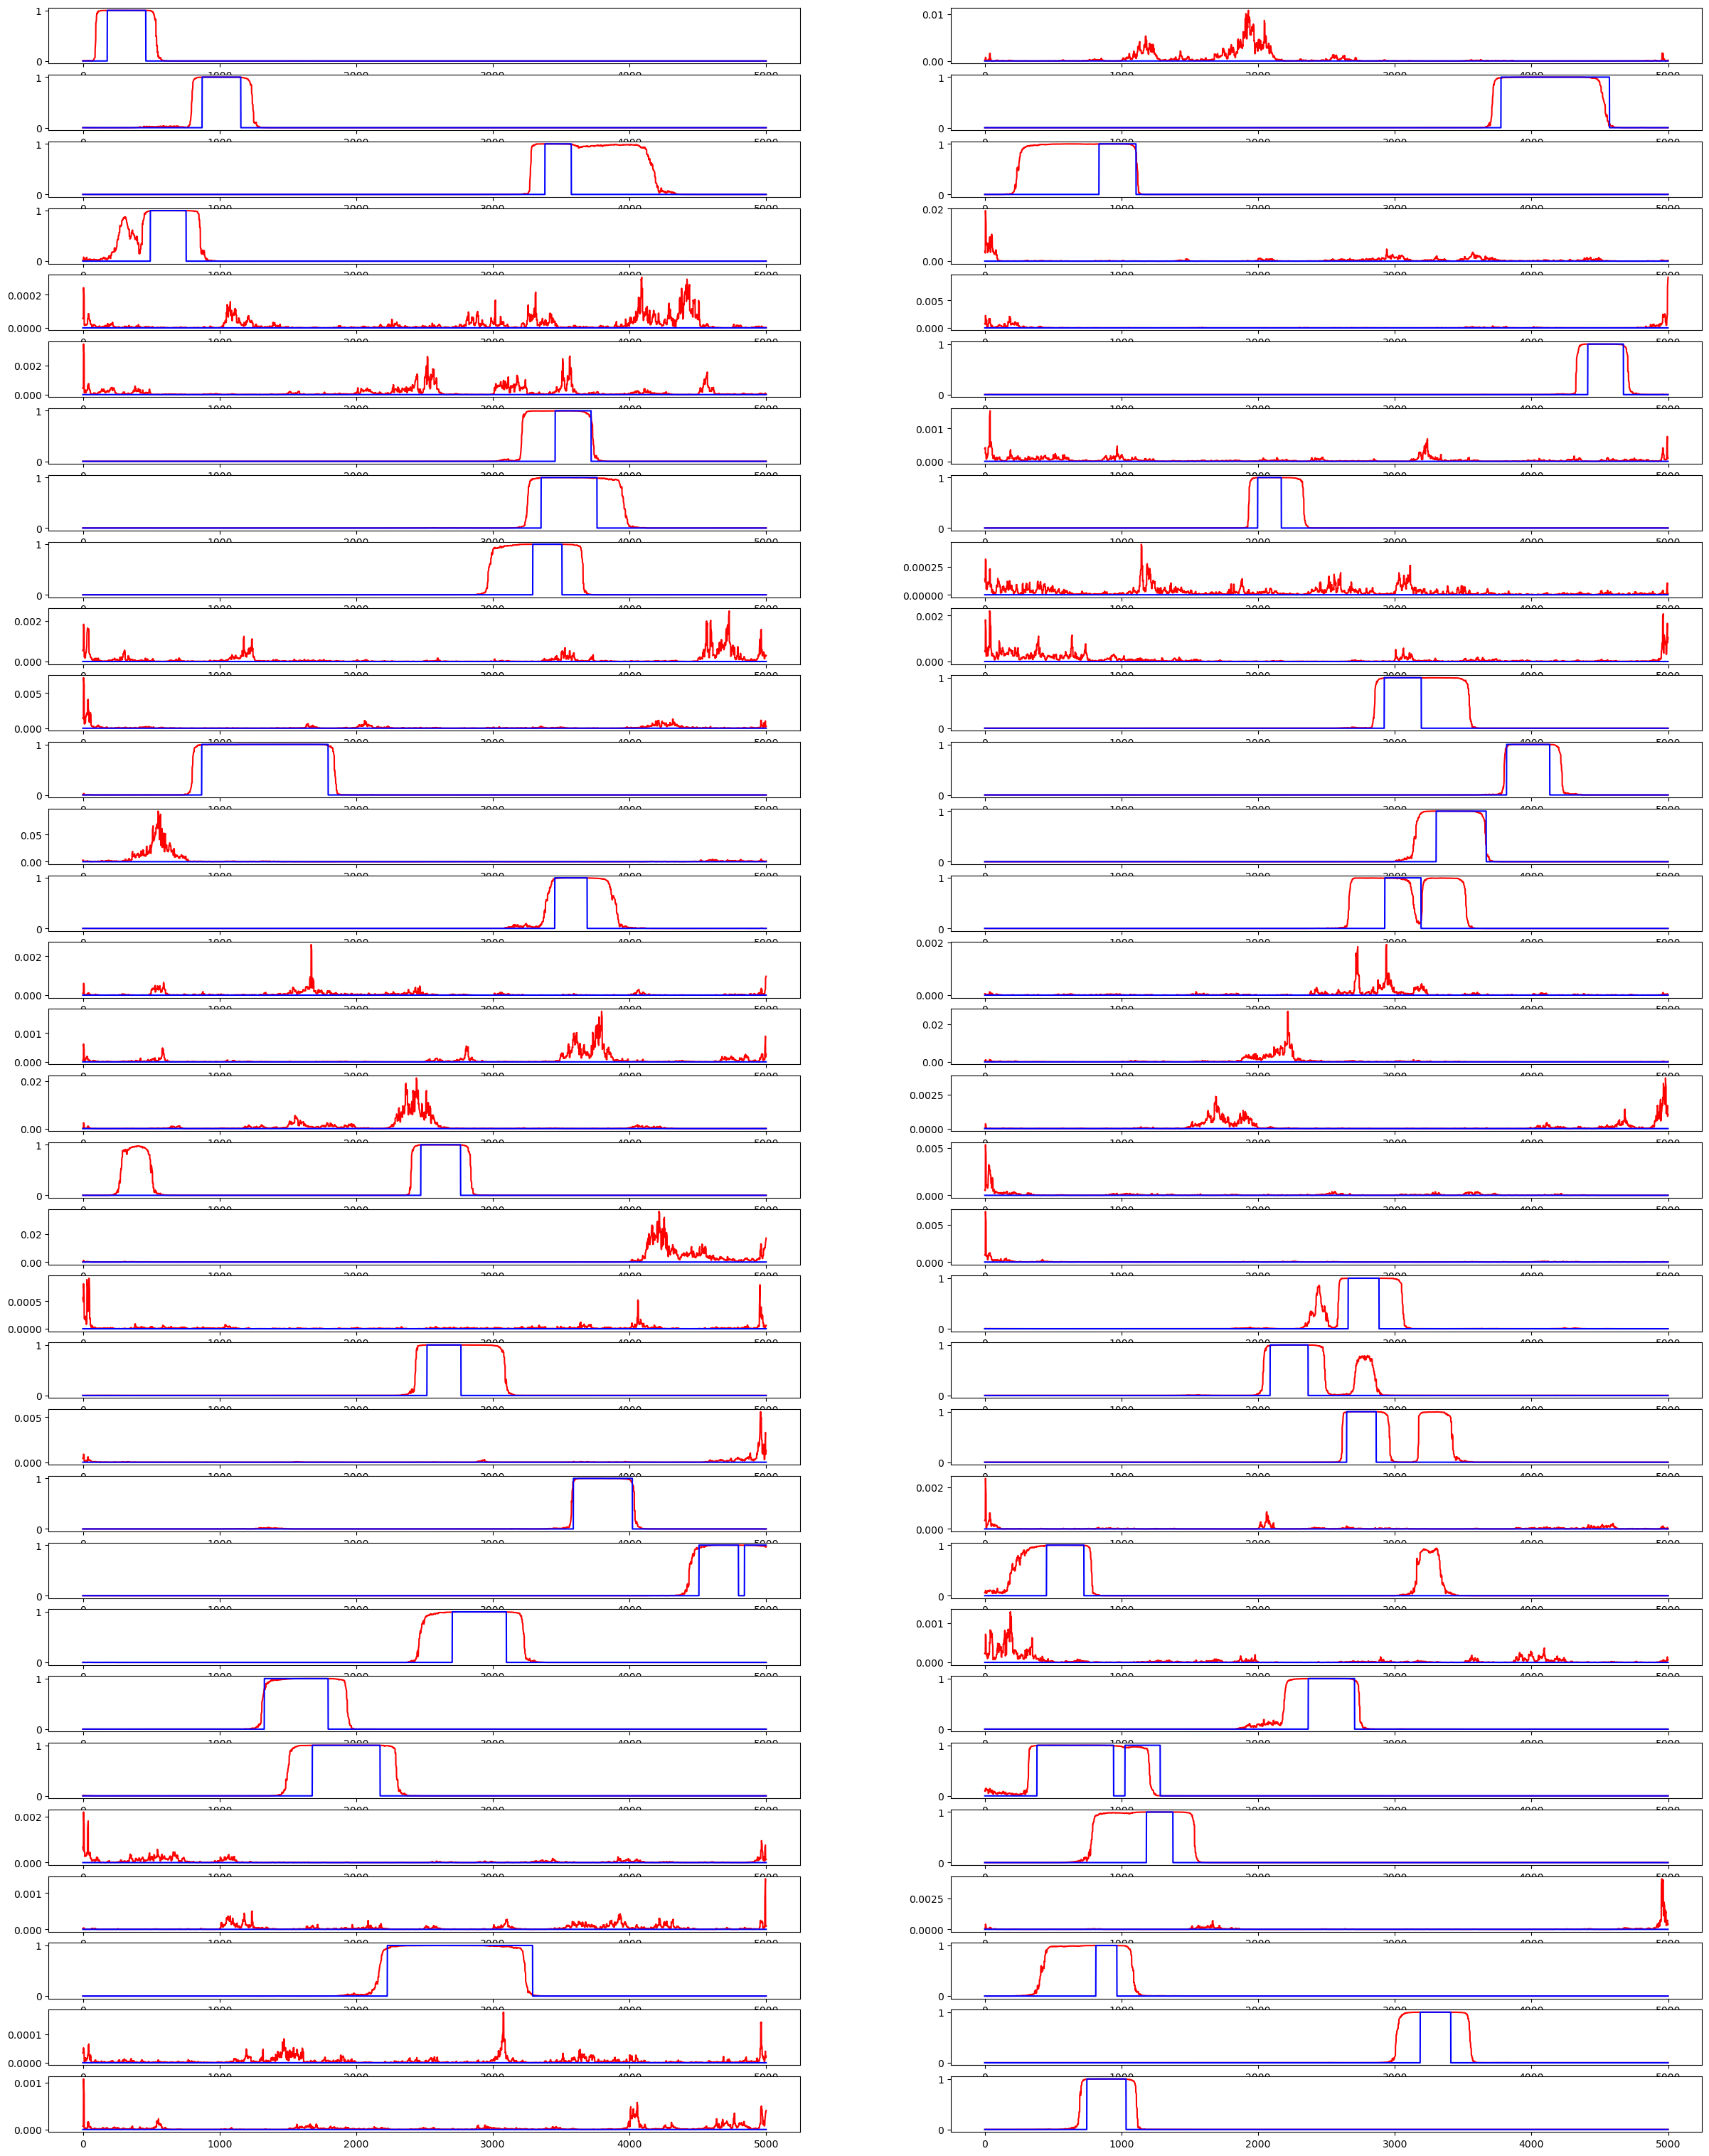

In [9]:
Evaluate.seeresult(train_loader,model,"hc",device)

/share/apps/anaconda3/envs/pytorch-gpu2/lib/python3.11/site-packages/torch/cuda/memory.py:329: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


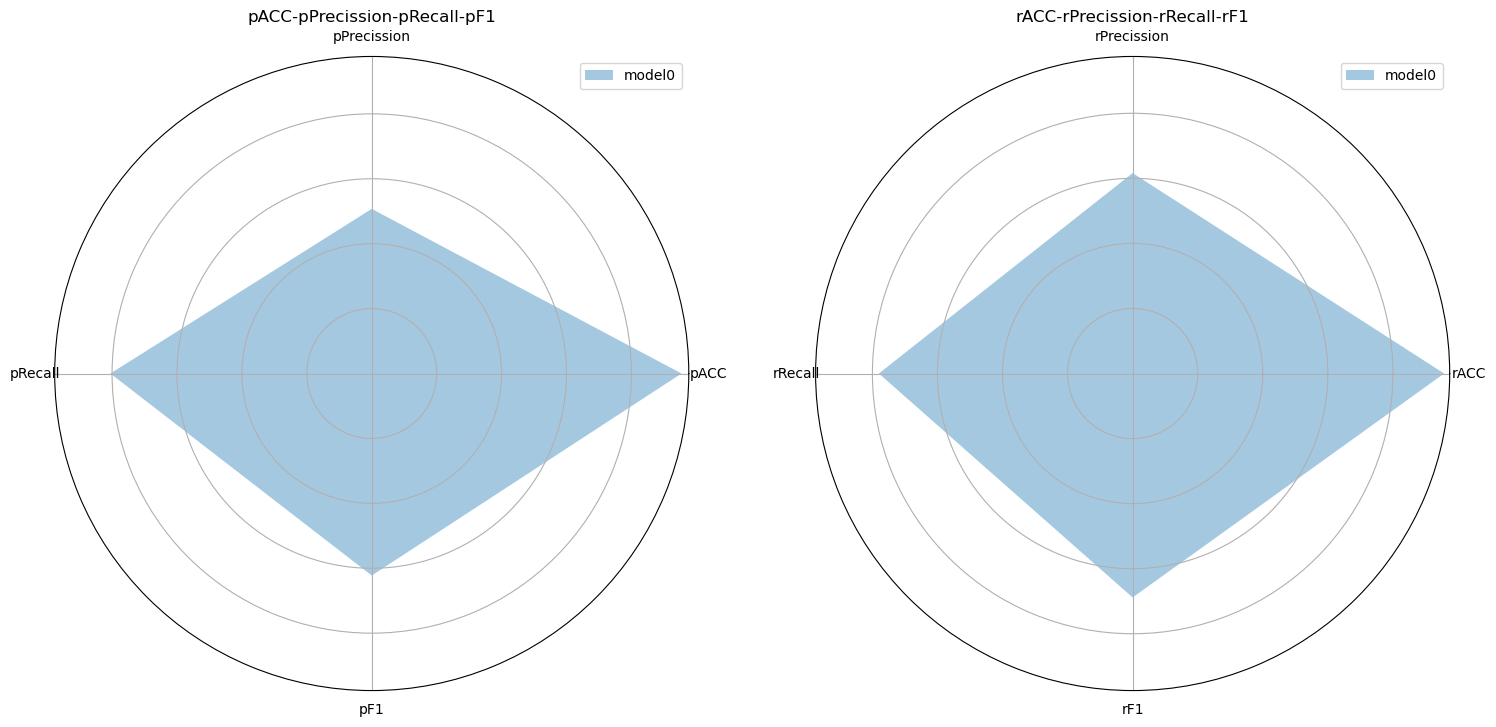

0.05 {'model0': [[0.9544171483791619, 0.5072239376789021, 0.8051690145353818, 0.6223760914909194], [0.9575772716624206, 0.6161999268865201, 0.7801297724566943, 0.6885421243649331]]}


In [27]:
re = Evaluate.CommonPlot(test_loader,[Model],[parafile],device,["hc"],0.05,windowlen,windowstep,param=[[]],savepath=None)

In [7]:
f.flush()

In [ ]:

model =None
Evaluate.get_p_roc(test_loader,[Model],[parafile],["hc"],names=["model a"],device=device)

In [ ]:
Evaluate.CommonPlot(train_loader,[Model],[parafile],device,["hc"],pvalue,windowlen,windowstep,savepath=None)